### 統計學習與深度學習
### Homework 5

##### R08725033 陳柏勳

請將IPYNB檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。

這個作業將要練習影像分類的問題。影像分類是CNN模型的強項，我們的任務是區分照片中主角穿的上衣類型。這個問題在不同的情境下有不同的難度。在`Dive into Deep Learning`中有類似的問題，但是處理較"乾淨"的影像。這次作業的資料來自街拍影像，因此分類的困難度較高。

我們這次作業的任務，是依照照片中人物的上衣，區分以下類別:
* blazer
* cardigan
* coat
* jacket

下面列出這四個類別的範例訓練資料。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/My Drive/photos')
os.listdir()

['photos']

Label =  blazer


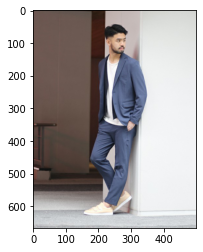

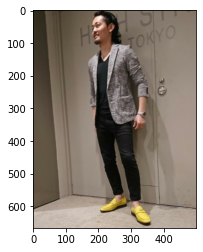

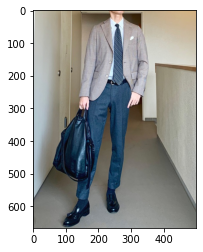

Label =  cardigan


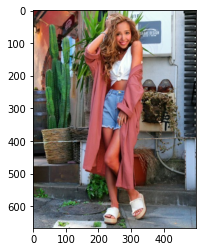

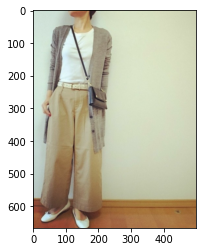

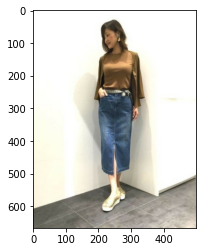

Label =  coat


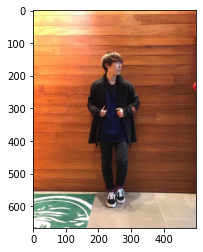

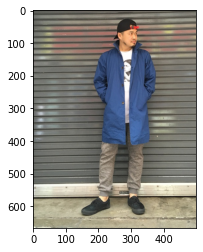

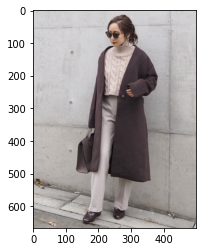

Label =  jacket


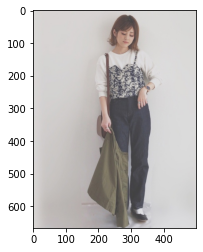

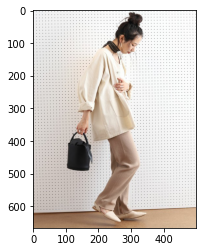

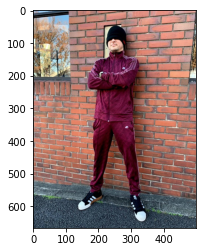

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random

random.seed(1223)
labels = ['blazer', 'cardigan', 'coat', 'jacket']
for i in range(4):
    print("Label = ", labels[i])
    basepath = os.path.join("photos/train", labels[i], "*.jpg")
    cand_fn = glob.glob(basepath)
    for afn in random.choices(cand_fn, k = 3):    
        img = Image.open(afn)
        plt.imshow(img)
        plt.show()

### 資料
資料在`photos`資料夾。已經區分好訓練(train)、校正(valid)、測試(test)資料。下一層則是依照圖片的標籤分資料夾存放，因此有四個資料夾，分別是blazer, cardigan, coat, jacket。一張圖片只會屬於一個類別。

### Q1
(5%) 列出train, valid, test的總照片數，以及各類別的照片數與比率。在還沒進行模型訓練與評估前，你認為各類別相對的準確率的大小關係為何?

* 以下針對三個set各建立一個1*5的矩陣，前面四個位置儲存各類的照片數，最後一個位置儲存整個set的照片數。

In [ ]:
# Show the numbers of photos
train_photo_num = [0]*(len(labels)+1)

for i in range(4):
  basepath = os.path.join("photos/train", labels[i], "*.jpg")
  cand_fn = glob.glob(basepath)
  train_photo_num[i] = len(cand_fn)
  train_photo_num[-1] += len(cand_fn)

print('train', train_photo_num[-1])

for i in range(4):
  print(labels[i], train_photo_num[i], train_photo_num[i]/train_photo_num[-1])

train 1050
blazer 97 0.09238095238095238
cardigan 237 0.2257142857142857
coat 296 0.2819047619047619
jacket 420 0.4


In [ ]:
valid_photo_num = [0]*(len(labels)+1)

for i in range(4):
  basepath = os.path.join("photos/valid", labels[i], "*.jpg")
  cand_fn = glob.glob(basepath)
  valid_photo_num[i] = len(cand_fn)
  valid_photo_num[-1] += len(cand_fn)

print('valid', valid_photo_num[-1])

for i in range(4):
  print(labels[i], valid_photo_num[i], valid_photo_num[i]/valid_photo_num[-1])

valid 105
blazer 7 0.06666666666666667
cardigan 36 0.34285714285714286
coat 27 0.2571428571428571
jacket 35 0.3333333333333333


In [ ]:
test_photo_num = [0]*(len(labels)+1)

for i in range(4):
  basepath = os.path.join("photos/test", labels[i], "*.jpg")
  cand_fn = glob.glob(basepath)
  test_photo_num[i] = len(cand_fn)
  test_photo_num[-1] += len(cand_fn)

print('test', test_photo_num[-1])

for i in range(4):
  print(labels[i], test_photo_num[i], test_photo_num[i]/test_photo_num[-1])

test 146
blazer 9 0.06164383561643835
cardigan 42 0.2876712328767123
coat 43 0.2945205479452055
jacket 52 0.3561643835616438


* train:1050，valid:105, test:146
* 從數字上來看，我認為相對準確率大小jacket>coat>cardigan>blazer，因排前面者擁有較多training data，有機會學到更多特徵
* 然而以服裝類別統一性而言，blazer>coat>cardigan,jacket，故實際結果不一定和training data數完全一致（西裝、大衣組內間比較像）

### Q2
(35%) 使用Resnet50建構圖片分類模型。將最後一層的Fully Connected Layer輸出維度改成4以符合本題任務需求。除了最後一層以外，使用torchvision提供的pretrained weights (`torchvision.models.resnet50(pretrained=True)`)初始化模型權重。使用train資料訓練模型，以valid資料決定Early Stopping的Epoch。Early Stopping的Patient參數設為20 Epochs。Batch size設為32。每一個Epoch計算一次Valid Loss，並記錄Valid Loss最低的模型。模型訓練最多200個Epochs。使用最佳模型在test資料計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的Valid Loss。

由於圖片的解析度較高，模型訓練前須將解析度調整(Resize)成較短邊為256像素的照片，然後隨機取大小為224x224的影像。接著隨機水平翻轉(Horizontal Flip)、隨機旋轉-20度到20度，並依照Pretrained ResNet的要求調整RGB的均數與標準差。
測試資料(Valid and Test)亦須先將解析度調整(Resize)成較短邊為256像素的照片，然後取圖片中心224x224的影像。

得到Per-Class Accuracy之後，請討論與Q1預期的差異與可能原因。

提示: 
* Pytorch Resnet pretrained model的說明請見 <https://pytorch.org/hub/pytorch_vision_resnet/>
* 本題的Test Accuracy應高於78%。

* 使用resnet50建立model
* transform後藉由ImageFolder建立dataloader


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

model = models.resnet50(pretrained = True)
## Change the last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
from torchvision import datasets, transforms

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'photos/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

* 印出一個batch確認結果

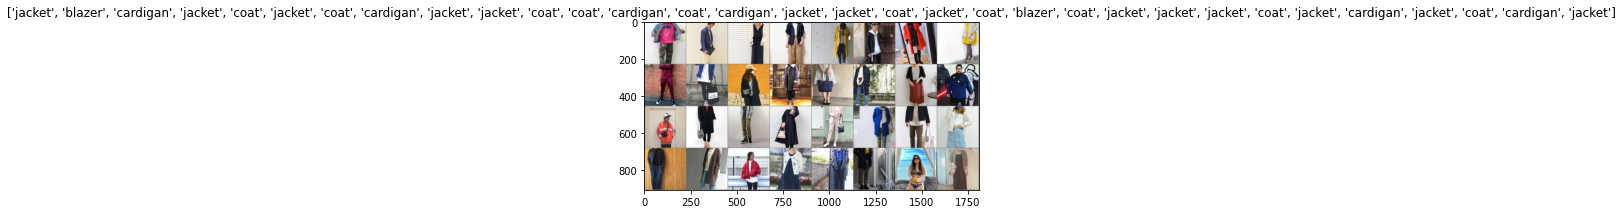

In [ ]:
import torchvision
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patient=20):
  since = time.time()
  patient_epoch = 0

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    #print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
      #    phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'valid' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        patient_epoch = 0
      else:
        patient_epoch += 1

    #print()

    if patient_epoch > patient-1:
      break

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, best_acc

* SGD考量lr = [0.001, 0.01, 0.1], m = [0.9, 0.95, 0.99]

In [ ]:
# Tuning
# https://towardsdatascience.com/hyper-parameter-tuning-techniques-in-deep-learning-4dad592c63c8
import torch.optim as optim
from torch.optim import lr_scheduler

lr_grid = [0.001, 0.01, 0.1]
m_grid = [0.9, 0.95, 0.99]
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
model_wts = []
model_info = []

# SGD
for lr in lr_grid:
  for m in m_grid:
    model = models.resnet50(pretrained = True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
    model = model.to(device)

    print('Model info: SGD,', 'lr =', lr, ', momentum =', m)
    print('-' * 10)

    optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=m)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200, patient=20)
    if acc > best_val_acc:
      best_val_acc = acc
      model_wts = copy.deepcopy(model.state_dict())
      model_info = ['SGD', lr, m]

Model info: SGD, lr = 0.001 , momentum = 0.9
----------
Training complete in 4m 45s
Best val Acc: 0.761905
Model info: SGD, lr = 0.001 , momentum = 0.95
----------
Training complete in 7m 36s
Best val Acc: 0.809524
Model info: SGD, lr = 0.001 , momentum = 0.99
----------
Training complete in 6m 9s
Best val Acc: 0.771429
Model info: SGD, lr = 0.01 , momentum = 0.9
----------
Training complete in 5m 41s
Best val Acc: 0.819048
Model info: SGD, lr = 0.01 , momentum = 0.95
----------
Training complete in 4m 44s
Best val Acc: 0.723810
Model info: SGD, lr = 0.01 , momentum = 0.99
----------
Training complete in 3m 29s
Best val Acc: 0.380952
Model info: SGD, lr = 0.1 , momentum = 0.9
----------
Training complete in 3m 43s
Best val Acc: 0.447619
Model info: SGD, lr = 0.1 , momentum = 0.95
----------
Training complete in 4m 39s
Best val Acc: 0.409524
Model info: SGD, lr = 0.1 , momentum = 0.99
----------
Training complete in 2m 31s
Best val Acc: 0.342857


* 因 lr = 0.1的狀況很差，故此處不考慮
* 實驗後發現lr = 0.01的Acc也太差，故最後考慮[0.0001, 0.001]
* Weight decay考量[0, 0.0001]

In [ ]:
# Adam
lr_grid = [0.0001, 0.001]
w_grid = [0, 0.0001] #https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9

for lr in lr_grid:
  for w in w_grid:
    model = models.resnet50(pretrained = True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
    model = model.to(device)

    print('Model info: Adam,', 'lr =', lr, ', weight decay =', w)
    print('-' * 10)

    optimizer_ft = optim.Adam(model.parameters(), lr=lr, weight_decay=w)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200, patient=20)
    if acc > best_val_acc:
      best_val_acc = acc
      model_wts = copy.deepcopy(model.state_dict())
      model_info = ['Adam', lr, w]

Model info: Adam, lr = 0.0001 , weight decay = 0
----------
Training complete in 5m 50s
Best val Acc: 0.866667
Model info: Adam, lr = 0.0001 , weight decay = 0.0001
----------
Training complete in 3m 4s
Best val Acc: 0.847619
Model info: Adam, lr = 0.001 , weight decay = 0
----------
Training complete in 3m 27s
Best val Acc: 0.685714
Model info: Adam, lr = 0.001 , weight decay = 0.0001
----------
Training complete in 4m 35s
Best val Acc: 0.657143


In [ ]:
# Best model
model_info

['Adam', 0.0001, 0]

In [ ]:
model = models.resnet50(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
model = model.to(device)
model.load_state_dict(model_wts)

# print model info
print('Model info:', model_info[0], 'lr =', model_info[1], ', weight decay =', model_info[2])
print('-' * 10)

# Testing
for phase in ['test']:
  
  model.eval()   # Set model to evaluate mode

  running_loss = 0.0
  running_corrects = 0
  confusion_matrix = torch.zeros(4, 4)

  # Iterate over data.
  for inputs, labels in dataloaders[phase]:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(phase == 'train'):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      for t, p in zip(labels.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / dataset_sizes[phase]
  epoch_acc = running_corrects.double() / dataset_sizes[phase]

  print('{} Loss: {:.4f} Acc: {:.4f}'.format(
      phase, epoch_loss, epoch_acc))
  
  print(confusion_matrix)

  print(confusion_matrix.diag()/confusion_matrix.sum(1))

Model info: Adam lr = 0.0001 , weight decay = 0
----------
test Loss: 0.4940 Acc: 0.8219
tensor([[ 7.,  0.,  1.,  1.],
        [ 1., 31.,  3.,  7.],
        [ 1.,  3., 36.,  3.],
        [ 5.,  1.,  0., 46.]])
tensor([0.7778, 0.7381, 0.8372, 0.8846])


* Tune出最佳的模型為Adam, lr=0.0001 (搭配lr衰減), weight decay=0
* Test Accuracy為0.8219，和Valid的落差很小，代表模型有學到有用的feature
* 準確度為4>3>1>2，大致上資料多的學得較好，但是Blazer應該是因為較一致，而分得比Cardigan好
* Adam optimizer lr = 0.001時表現就開始急遽下降，類似SGD lr = 0.1
* 加入weight decay都導致模型惡化

In [ ]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html



### Q3
(30%) 使用Resnet50建構圖片分類模型。將最後一層的Fully Connected Layer輸出維度改成4以符合本題任務需求。除了最後一層以外，使用torchvision提供的pretrained weights (`torchvision.models.resnet50(pretrained=True)`)初始化模型權重。模型訓練時固定除了最後一層以外的其他權重。也就是說，模型訓練只會調整最後一層Fully Connected Layer。圖片前處理與前題一致。

使用train訓練模型，以valid決定early stopping的epoch。Early stopping的patient參數為20 epochs。Batch size設為32。紀錄valid loss最低的模型，並在test中計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的valid loss。

* SGD考量lr = [0.001, 0.01, 0.1], m = [0.9, 0.95, 0.99]
* fc layer以外的參數`requires_grad = False`
* optimizer只針對`model.fc.parameters()`

In [ ]:
# Tuning

lr_grid = [0.001, 0.01, 0.1]
m_grid = [0.9, 0.95, 0.99]
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
model_wts = []
model_info = []

# SGD
for lr in lr_grid:
  for m in m_grid:
    model = models.resnet50(pretrained = True)
    # Only optimize fc layer
    for param in model.parameters():
      param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
    model = model.to(device)

    print('Model info: SGD,', 'lr =', lr, ', momentum =', m)
    print('-' * 10)

    optimizer_ft = optim.SGD(model.fc.parameters(), lr=lr, momentum=m) # Only fc
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200, patient=20)
    if acc > best_val_acc:
      best_val_acc = acc
      model_wts = copy.deepcopy(model.state_dict())
      model_info = ['SGD', lr, m]

Model info: SGD, lr = 0.001 , momentum = 0.9
----------
Training complete in 2m 47s
Best val Acc: 0.571429
Model info: SGD, lr = 0.001 , momentum = 0.95
----------
Training complete in 2m 45s
Best val Acc: 0.600000
Model info: SGD, lr = 0.001 , momentum = 0.99
----------
Training complete in 4m 57s
Best val Acc: 0.619048
Model info: SGD, lr = 0.01 , momentum = 0.9
----------
Training complete in 2m 43s
Best val Acc: 0.609524
Model info: SGD, lr = 0.01 , momentum = 0.95
----------
Training complete in 3m 34s
Best val Acc: 0.600000
Model info: SGD, lr = 0.01 , momentum = 0.99
----------
Training complete in 2m 52s
Best val Acc: 0.619048
Model info: SGD, lr = 0.1 , momentum = 0.9
----------
Training complete in 3m 13s
Best val Acc: 0.571429
Model info: SGD, lr = 0.1 , momentum = 0.95
----------
Training complete in 3m 13s
Best val Acc: 0.590476
Model info: SGD, lr = 0.1 , momentum = 0.99
----------
Training complete in 3m 43s
Best val Acc: 0.628571


In [ ]:
# Tuning
lr_grid = [0.0001]
m_grid = [0.9]

# SGD
for lr in lr_grid:
  for m in m_grid:
    model = models.resnet50(pretrained = True)
    # Only optimize fc layer
    for param in model.parameters():
      param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
    model = model.to(device)

    print('Model info: SGD,', 'lr =', lr, ', momentum =', m)
    print('-' * 10)

    optimizer_ft = optim.SGD(model.fc.parameters(), lr=lr, momentum=m) # Only fc
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200, patient=20)
    if acc > best_val_acc:
      best_val_acc = acc
      model_wts = copy.deepcopy(model.state_dict())
      model_info = ['SGD', lr, m]

Model info: SGD, lr = 0.0001 , momentum = 0.9
----------
Training complete in 16m 8s
Best val Acc: 0.419048


In [ ]:
# Tuning
lr_grid = [0.2]
m_grid = [0.9]

# SGD
for lr in lr_grid:
  for m in m_grid:
    model = models.resnet50(pretrained = True)
    # Only optimize fc layer
    for param in model.parameters():
      param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
    model = model.to(device)

    print('Model info: SGD,', 'lr =', lr, ', momentum =', m)
    print('-' * 10)

    optimizer_ft = optim.SGD(model.fc.parameters(), lr=lr, momentum=m) # Only fc
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200, patient=20)
    if acc > best_val_acc:
      best_val_acc = acc
      model_wts = copy.deepcopy(model.state_dict())
      model_info = ['SGD', lr, m]

Model info: SGD, lr = 0.2 , momentum = 0.9
----------
Training complete in 15m 41s
Best val Acc: 0.600000


* SGD表現最好的Acc為0.628571, lr=0.1, m=0.99
* 再調大調小lr都沒有明顯幫助
* 跟Q2不同的是lr變大沒有明顯變差（跑離最佳解）
* Adam一樣考慮lr = [0.0001, 0.001]，Weight decay考量[0, 0.0001]

In [ ]:
# Adam
lr_grid = [0.0001, 0.001]
w_grid = [0, 0.0001]

for lr in lr_grid:
  for w in w_grid:
    model = models.resnet50(pretrained = True)
    # Only optimize fc layer
    for param in model.parameters():
      param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
    model = model.to(device)

    print('Model info: Adam,', 'lr =', lr, ', weight decay =', w)
    print('-' * 10)

    optimizer_ft = optim.Adam(model.fc.parameters(), lr=lr, weight_decay=w)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200, patient=20)
    if acc > best_val_acc:
      best_val_acc = acc
      model_wts = copy.deepcopy(model.state_dict())
      model_info = ['Adam', lr, w]

Model info: Adam, lr = 0.0001 , weight decay = 0
----------
Training complete in 4m 18s
Best val Acc: 0.504762
Model info: Adam, lr = 0.0001 , weight decay = 0.0001
----------
Training complete in 5m 39s
Best val Acc: 0.495238
Model info: Adam, lr = 0.001 , weight decay = 0
----------
Training complete in 3m 34s
Best val Acc: 0.590476
Model info: Adam, lr = 0.001 , weight decay = 0.0001
----------
Training complete in 2m 57s
Best val Acc: 0.580952


* lr = 0.001優於0.0001，故再嘗試lr = 0.01

In [ ]:
# Adam
lr_grid = [0.01]
w_grid = [0, 0.0001]

for lr in lr_grid:
  for w in w_grid:
    model = models.resnet50(pretrained = True)
    # Only optimize fc layer
    for param in model.parameters():
      param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
    model = model.to(device)

    print('Model info: Adam,', 'lr =', lr, ', weight decay =', w)
    print('-' * 10)

    optimizer_ft = optim.Adam(model.fc.parameters(), lr=lr, weight_decay=w)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200, patient=20)
    if acc > best_val_acc:
      best_val_acc = acc
      model_wts = copy.deepcopy(model.state_dict())
      model_info = ['Adam', lr, w]

Model info: Adam, lr = 0.01 , weight decay = 0
----------
Training complete in 4m 6s
Best val Acc: 0.628571
Model info: Adam, lr = 0.01 , weight decay = 0.0001
----------
Training complete in 4m 5s
Best val Acc: 0.600000


* Weight Decay都導致更差的valid Acc
* 因 Adam的最佳Acc和SGD一樣，然SGD再次訓練後結果落差較大（Acc=0.59），故以Adam進行預測

In [ ]:
model = models.resnet50(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
model = model.to(device)
model.load_state_dict(model_wts)

# print model info
print('Model info:', model_info[0], 'lr =', model_info[1], ', weight decay =', model_info[2])
print('-' * 10)

# Testing
for phase in ['test']:
  
  model.eval()   # Set model to evaluate mode

  running_loss = 0.0
  running_corrects = 0
  confusion_matrix = torch.zeros(4, 4)

  # Iterate over data.
  for inputs, labels in dataloaders[phase]:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(phase == 'train'):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      for t, p in zip(labels.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / dataset_sizes[phase]
  epoch_acc = running_corrects.double() / dataset_sizes[phase]

  print('{} Loss: {:.4f} Acc: {:.4f}'.format(
      phase, epoch_loss, epoch_acc))
  
  print(confusion_matrix)

  print(confusion_matrix.diag()/confusion_matrix.sum(1))

Model info: Adam lr = 0.01 , weight decay = 0
----------
test Loss: 0.9545 Acc: 0.6644
tensor([[ 6.,  0.,  0.,  3.],
        [ 0., 23., 10.,  9.],
        [ 3.,  4., 30.,  6.],
        [ 2.,  3.,  9., 38.]])
tensor([0.6667, 0.5476, 0.6977, 0.7308])


* Tune出最佳的模型為Adam, lr=0.01 (搭配lr衰減), weight decay=0
* Test Accuracy為0.6644，比Valid略高，代表模型有學到有用的feature
* 只改動fc的狀況下，模型的學習遇到較大的困難（pretrained的學習內容和我們的資料集不完全相同）
* 準確度為4>3>1>2，大致上資料多的學得較好，但是Blazer應該是因為較一致，而分得比Cardigan好
* lr不夠時表現很差（Adam = 0.0001, SGD = 0.001），即需要相對Q2高的lr
* 加入weight decay都導致模型惡化

### Q4
(20%) 使用Resnet50建構圖片分類模型。將最後一層的fully connected layer輸出維度改成4以符合本題任務需求。圖片前處理與前題一致。不使用預訓練權重初始化模型。使用train訓練模型，以valid決定early stopping的epoch。Early stopping的patient參數為20 epochs。Batch size設為32。紀錄valid loss最低的模型，並在test中計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的valid loss。
* SGD考量lr = [0.001, 0.01, 0.1], m = [0.9, 0.95, 0.99]
* 不使用預訓練權重，`pretrained = False`


In [ ]:
# No pretrained
# Tuning
lr_grid = [0.001, 0.01, 0.1]
m_grid = [0.9, 0.95, 0.99]
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
model_wts = []
model_info = []

# SGD
for lr in lr_grid:
  for m in m_grid:
    model = models.resnet50(pretrained = False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
    model = model.to(device)

    print('Model info: SGD,', 'lr =', lr, ', momentum =', m)
    print('-' * 10)

    optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=m)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200, patient=20)
    if acc > best_val_acc:
      best_val_acc = acc
      model_wts = copy.deepcopy(model.state_dict())
      model_info = ['SGD', lr, m]

Model info: SGD, lr = 0.001 , momentum = 0.9
----------
Training complete in 13m 59s
Best val Acc: 0.428571
Model info: SGD, lr = 0.001 , momentum = 0.95
----------
Training complete in 6m 15s
Best val Acc: 0.419048
Model info: SGD, lr = 0.001 , momentum = 0.99
----------
Training complete in 6m 59s
Best val Acc: 0.457143
Model info: SGD, lr = 0.01 , momentum = 0.9
----------
Training complete in 3m 8s
Best val Acc: 0.438095
Model info: SGD, lr = 0.01 , momentum = 0.95
----------
Training complete in 5m 3s
Best val Acc: 0.400000
Model info: SGD, lr = 0.01 , momentum = 0.99
----------
Training complete in 3m 6s
Best val Acc: 0.371429
Model info: SGD, lr = 0.1 , momentum = 0.9
----------
Training complete in 4m 18s
Best val Acc: 0.409524
Model info: SGD, lr = 0.1 , momentum = 0.95
----------
Training complete in 4m 47s
Best val Acc: 0.352381
Model info: SGD, lr = 0.1 , momentum = 0.99
----------
Training complete in 3m 19s
Best val Acc: 0.361905


* SGD的表現和Q2相似，lr = 0.1時Acc很低
* 最佳為lr = 0.001, m = 0.99，Acc = 0.457143
* 故Adam一樣考慮lr = [0.0001, 0.001]，Weight decay考量[0, 0.0001]

In [ ]:
# Adam
lr_grid = [0.0001, 0.001]
w_grid = [0, 0.0001]

for lr in lr_grid:
  for w in w_grid:
    model = models.resnet50(pretrained = False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
    model = model.to(device)

    print('Model info: Adam,', 'lr =', lr, ', weight decay =', w)
    print('-' * 10)

    optimizer_ft = optim.Adam(model.parameters(), lr=lr, weight_decay=w)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200, patient=20)
    if acc > best_val_acc:
      best_val_acc = acc
      model_wts = copy.deepcopy(model.state_dict())
      model_info = ['Adam', lr, w]

Model info: Adam, lr = 0.0001 , weight decay = 0
----------
Training complete in 3m 25s
Best val Acc: 0.438095
Model info: Adam, lr = 0.0001 , weight decay = 0.0001
----------
Training complete in 4m 40s
Best val Acc: 0.447619
Model info: Adam, lr = 0.001 , weight decay = 0
----------
Training complete in 7m 48s
Best val Acc: 0.504762
Model info: Adam, lr = 0.001 , weight decay = 0.0001
----------
Training complete in 7m 5s
Best val Acc: 0.495238


* lr = 0.001優於0.0001，故再嘗試lr = 0.01

In [ ]:
# Adam
lr_grid = [0.01]
w_grid = [0, 0.0001]

for lr in lr_grid:
  for w in w_grid:
    model = models.resnet50(pretrained = False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
    model = model.to(device)

    print('Model info: Adam,', 'lr =', lr, ', weight decay =', w)
    print('-' * 10)

    optimizer_ft = optim.Adam(model.parameters(), lr=lr, weight_decay=w)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200, patient=20)
    if acc > best_val_acc:
      best_val_acc = acc
      model_wts = copy.deepcopy(model.state_dict())
      model_info = ['Adam', lr, w]

Model info: Adam, lr = 0.01 , weight decay = 0
----------
Training complete in 2m 40s
Best val Acc: 0.333333
Model info: Adam, lr = 0.01 , weight decay = 0.0001
----------
Training complete in 5m 49s
Best val Acc: 0.438095


In [ ]:
model = models.resnet50(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) # 2048, 4, bottleneck
model = model.to(device)
model.load_state_dict(model_wts)

# print model info
print('Model info:', model_info[0], 'lr =', model_info[1], ', weight decay =', model_info[2])
print('-' * 10)

# Testing
for phase in ['test']:
  
  model.eval()   # Set model to evaluate mode

  running_loss = 0.0
  running_corrects = 0
  confusion_matrix = torch.zeros(4, 4)

  # Iterate over data.
  for inputs, labels in dataloaders[phase]:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(phase == 'train'):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      for t, p in zip(labels.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / dataset_sizes[phase]
  epoch_acc = running_corrects.double() / dataset_sizes[phase]

  print('{} Loss: {:.4f} Acc: {:.4f}'.format(
      phase, epoch_loss, epoch_acc))
  
  print(confusion_matrix)

  print(confusion_matrix.diag()/confusion_matrix.sum(1))

Model info: Adam lr = 0.001 , weight decay = 0
----------
test Loss: 1.2006 Acc: 0.4384
tensor([[ 0.,  0.,  3.,  6.],
        [ 1., 15.,  8., 18.],
        [ 0., 15., 10., 18.],
        [ 0.,  7.,  6., 39.]])
tensor([0.0000, 0.3571, 0.2326, 0.7500])


* 最佳的參數為Adam, lr = 0.001, weight decay = 0
* Test Acc為0.4384，跟valid acc有相對明顯的差距，代表模型學到的特徵可能不夠Generalize
* 準確度為4>>>2>3>1，大致上資料多的學得較好，基本上只有jacket比較能辨識
* Cardigan優於coat，Brazer或許因為比數少，完全無法辨識
* Resnet50的參數對於1000筆資料來說太多，無法被成功訓練
* 和Q2,3不同，Adam有2/3的狀況weight decay有用（L2 Regularization）

### Q5
(10%) 統整併討論Q2-Q4的預測能力。說明你的觀察。

* Test Acc Q2 >>> Q3 >>> Q4
* 代表1000筆資料對於pretrained model微調尚算足夠（Q2），從頭訓練則無法（Q4）
* Q3反映pretrain的資料和作業不同，因此只改動fc會受到限制
* Q2, Q3的預測表現較平均，Q4很極端的只有jacket叫好，甚至優於Q3→合理推斷模型不會就猜jacket，因為他是majority class
* Adam需要較小的lr，SGD則可較大
* Weight decay在Q4這種表現較差的情況下比較有用